# Machine Learning Methods for Early Prediction of <br>End-of-Life for Lithium-ion Batteries

James Chapman <br>
CIS 732 Machine Learning – Term Project<br>
Kansas State University<br>

This notebook processes data from the dataset used in “Data-driven prediction of battery cycle life before capacity degradation”, Severson, et al. (https://www.nature.com/articles/s41560-019-0356-8) which consists of 124 commercial lithium-ion batteries cycled to failure.

4 Pandas dataframes are created from the same summary data used in Severson, et al.<br>

    TabularSummaryBatteryData.csv- Summary data for First 100 cycles 
    TabularSummaryBatteryData60.csv- Summary data for First 60 cycles
    TabularSummaryBatteryData40.csv- Summary data for First 40 cycles
    TabularSummaryBatteryData20.csv- Summary data for First 20 cycles 

3 Pytorch Tensors are created from the linearly interpolated discharge capacity values (labeled 'Qdlin' in the Battery dictionary)<br>

    DischargeCapacity-InterpolatedData_Train.pt 
        - 41 batteries X 99 cycles X 100 Linearly interpolated discharge capacity values
    DischargeCapacity-InterpolatedData_Test.pt 
        - 42 batteries X 99 cycles X 100 Linearly interpolated discharge capacity values
    DischargeCapacity-InterpolatedData_Secondary_Test.pt 
        - 40 batteries X 99 cycles X 100 Linearly interpolated discharge capacity values


The raw data is a Dictionary With 8 keys: 

    ['Vdlin', 'barcode', 'channel_id', 'cycle_life', 'cycles', 'policy', 'policy_readable', 'summary'] 
    
    'cycle_life' is an integer, and the target of machine learning. 
    It is the number of cycles until the battery fails
    
    'summary' is a Nested dictionary with 8 keys:
    ['IR', 'QC', 'QD', 'Tavg', 'Tmin', 'Tmax', 'chargetime', 'cycle']
        *The length of each of the 8 arrays is the cycle_life(int) Of the cell
        *Each value of The 8 arrays Correspondences to each cycle of the cell
    
    'cycles' is a Nested dictionary with cycle_life(int) number of keys:
    ['1', '2', … 'cycle_life'(int)]
        Each key In 'cycles' Is a nested dictionary with 8 keys:
        ['I', 'Qc', 'Qd', 'Qdlin', 'T', 'Tdlin', 'V', 'dQdV', 't']
             *The length of each of the arrays is the Length of time 't' of each cycle
             *With the exception of 'Qdlin' & 'Tdlin', Which is normalized to Array length 1000
             
#######
          
Supplementary Information provided by Severson, et al.  
    (https://www.nature.com/articles/s41560-019-0356-8#Sec10)<br>
    https://static-content.springer.com/esm/art%3A10.1038%2Fs41560-019-0356-8/MediaObjects/41560_2019_356_MOESM1_ESM.pdf

In [123]:
import h5py
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
from scipy.stats import skew,kurtosis
from sklearn import preprocessing
from sklearn.linear_model import ElasticNet,LinearRegression,ElasticNetCV
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import GridSearchCV,train_test_split

########################################

Original data 
from https://data.matr.io/1/projects/5c48dd2bc625d700019f3204

########################################

In [124]:
matFilename1 = r'data/2017-05-12_batchdata_updated_struct_errorcorrect.mat'
matFilename2 = r'data/2017-06-30_batchdata_updated_struct_errorcorrect.mat'
matFilename3 = r'data/2018-04-12_batchdata_updated_struct_errorcorrect.mat'

################################################################################

The following code is directly copied from the author's GitHubFor preprocessing the raw data

https://github.com/rdbraatz/data-driven-prediction-of-battery-cycle-life-before-capacity-degradation

################################################################################

In [125]:
f = h5py.File(matFilename1)
batch=f['batch']
num_cells = batch['summary'].shape[0]
bat_dict = {}
for i in range(num_cells):
    cl = f[batch['cycle_life'][i,0]][()]
    policy = f[batch['policy_readable'][i,0]][()].tobytes()[::2].decode()
    summary_IR = np.hstack(f[batch['summary'][i,0]]['IR'][0,:].tolist())
    summary_QC = np.hstack(f[batch['summary'][i,0]]['QCharge'][0,:].tolist())
    summary_QD = np.hstack(f[batch['summary'][i,0]]['QDischarge'][0,:].tolist())
    summary_TA = np.hstack(f[batch['summary'][i,0]]['Tavg'][0,:].tolist())
    summary_TM = np.hstack(f[batch['summary'][i,0]]['Tmin'][0,:].tolist())
    summary_TX = np.hstack(f[batch['summary'][i,0]]['Tmax'][0,:].tolist())
    summary_CT = np.hstack(f[batch['summary'][i,0]]['chargetime'][0,:].tolist())
    summary_CY = np.hstack(f[batch['summary'][i,0]]['cycle'][0,:].tolist())
    summary = {'IR': summary_IR, 'QC': summary_QC, 'QD': summary_QD, 'Tavg':
                summary_TA, 'Tmin': summary_TM, 'Tmax': summary_TX, 'chargetime': summary_CT,
                'cycle': summary_CY}
    cycles = f[batch['cycles'][i,0]]
    cycle_dict = {}
    for j in range(cycles['I'].shape[0]):
        I = np.hstack((f[cycles['I'][j,0]][()]))
        Qc = np.hstack((f[cycles['Qc'][j,0]][()]))
        Qd = np.hstack((f[cycles['Qd'][j,0]][()]))
        Qdlin = np.hstack((f[cycles['Qdlin'][j,0]][()]))
        T = np.hstack((f[cycles['T'][j,0]][()]))
        Tdlin = np.hstack((f[cycles['Tdlin'][j,0]][()]))
        V = np.hstack((f[cycles['V'][j,0]][()]))
        dQdV = np.hstack((f[cycles['discharge_dQdV'][j,0]][()]))
        t = np.hstack((f[cycles['t'][j,0]][()]))
        cd = {'I': I, 'Qc': Qc, 'Qd': Qd, 'Qdlin': Qdlin, 'T': T, 'Tdlin': Tdlin, 'V':V, 'dQdV': dQdV, 't':t}
        cycle_dict[str(j)] = cd
        
    cell_dict = {'cycle_life': cl, 'charge_policy':policy, 'summary': summary, 'cycles': cycle_dict}
    key = 'b1c' + str(i)
    bat_dict[key]=   cell_dict
    
batch_dict1 = bat_dict

#Batch2

In [126]:
f = h5py.File(matFilename2)
batch=f['batch']
num_cells = batch['summary'].shape[0]
bat_dict = {}
for i in range(num_cells):
    cl = f[batch['cycle_life'][i,0]][()]
    policy = f[batch['policy_readable'][i,0]][()].tobytes()[::2].decode()
    summary_IR = np.hstack(f[batch['summary'][i,0]]['IR'][0,:].tolist())
    summary_QC = np.hstack(f[batch['summary'][i,0]]['QCharge'][0,:].tolist())
    summary_QD = np.hstack(f[batch['summary'][i,0]]['QDischarge'][0,:].tolist())
    summary_TA = np.hstack(f[batch['summary'][i,0]]['Tavg'][0,:].tolist())
    summary_TM = np.hstack(f[batch['summary'][i,0]]['Tmin'][0,:].tolist())
    summary_TX = np.hstack(f[batch['summary'][i,0]]['Tmax'][0,:].tolist())
    summary_CT = np.hstack(f[batch['summary'][i,0]]['chargetime'][0,:].tolist())
    summary_CY = np.hstack(f[batch['summary'][i,0]]['cycle'][0,:].tolist())
    summary = {'IR': summary_IR, 'QC': summary_QC, 'QD': summary_QD, 'Tavg':
                summary_TA, 'Tmin': summary_TM, 'Tmax': summary_TX, 'chargetime': summary_CT,
                'cycle': summary_CY}
    cycles = f[batch['cycles'][i,0]]
    cycle_dict = {}
    for j in range(cycles['I'].shape[0]):
        I = np.hstack((f[cycles['I'][j,0]][()]))
        Qc = np.hstack((f[cycles['Qc'][j,0]][()]))
        Qd = np.hstack((f[cycles['Qd'][j,0]][()]))
        Qdlin = np.hstack((f[cycles['Qdlin'][j,0]][()]))
        T = np.hstack((f[cycles['T'][j,0]][()]))
        Tdlin = np.hstack((f[cycles['Tdlin'][j,0]][()]))
        V = np.hstack((f[cycles['V'][j,0]][()]))
        dQdV = np.hstack((f[cycles['discharge_dQdV'][j,0]][()]))
        t = np.hstack((f[cycles['t'][j,0]][()]))
        cd = {'I': I, 'Qc': Qc, 'Qd': Qd, 'Qdlin': Qdlin, 'T': T, 'Tdlin': Tdlin, 'V':V, 'dQdV': dQdV, 't':t}
        cycle_dict[str(j)] = cd
        
    cell_dict = {'cycle_life': cl, 'charge_policy':policy, 'summary': summary, 'cycles': cycle_dict}
    key = 'b2c' + str(i)
    bat_dict[key]=   cell_dict
    
batch_dict2 = bat_dict

Batch 3

In [127]:
f = h5py.File(matFilename3)
batch=f['batch']
num_cells = batch['summary'].shape[0]
x=range(num_cells)
bat_dict = {}
for i in x:
    cl = f[batch['cycle_life'][i,0]][()]
    policy = f[batch['policy_readable'][i,0]][()].tobytes()[::2].decode()
    summary_IR = np.hstack(f[batch['summary'][i,0]]['IR'][0,:].tolist())
    summary_QC = np.hstack(f[batch['summary'][i,0]]['QCharge'][0,:].tolist())
    summary_QD = np.hstack(f[batch['summary'][i,0]]['QDischarge'][0,:].tolist())
    summary_TA = np.hstack(f[batch['summary'][i,0]]['Tavg'][0,:].tolist())
    summary_TM = np.hstack(f[batch['summary'][i,0]]['Tmin'][0,:].tolist())
    summary_TX = np.hstack(f[batch['summary'][i,0]]['Tmax'][0,:].tolist())
    summary_CT = np.hstack(f[batch['summary'][i,0]]['chargetime'][0,:].tolist())
    summary_CY = np.hstack(f[batch['summary'][i,0]]['cycle'][0,:].tolist())
    summary = {'IR': summary_IR, 'QC': summary_QC, 'QD': summary_QD, 'Tavg':
                summary_TA, 'Tmin': summary_TM, 'Tmax': summary_TX, 'chargetime': summary_CT,
                'cycle': summary_CY}
    cycles = f[batch['cycles'][i,0]]
    cycle_dict = {}
    for j in range(cycles['I'].shape[0]):
        I = np.hstack((f[cycles['I'][j,0]][()]))
        Qc = np.hstack((f[cycles['Qc'][j,0]][()]))
        Qd = np.hstack((f[cycles['Qd'][j,0]][()]))
        Qdlin = np.hstack((f[cycles['Qdlin'][j,0]][()]))
        T = np.hstack((f[cycles['T'][j,0]][()]))
        Tdlin = np.hstack((f[cycles['Tdlin'][j,0]][()]))
        V = np.hstack((f[cycles['V'][j,0]][()]))
        dQdV = np.hstack((f[cycles['discharge_dQdV'][j,0]][()]))
        t = np.hstack((f[cycles['t'][j,0]][()]))
        cd = {'I': I, 'Qc': Qc, 'Qd': Qd, 'Qdlin': Qdlin, 'T': T, 'Tdlin': Tdlin, 'V':V, 'dQdV': dQdV, 't':t}
        cycle_dict[str(j)] = cd
        
    cell_dict = {'cycle_life': cl, 'charge_policy':policy, 'summary': summary, 'cycles': cycle_dict}
    key = 'b3c' + str(i)
    bat_dict[key]=   cell_dict
    
batch_dict3 = bat_dict

batch.keys()

<KeysViewHDF5 ['Vdlin', 'barcode', 'channel_id', 'cycle_life', 'cycles', 'policy', 'policy_readable', 'summary']>

In [128]:
batch1 = batch_dict1.copy()
batch2 = batch_dict2.copy()
batch3 = batch_dict3.copy()

del batch1['b1c8']
del batch1['b1c10']
del batch1['b1c12']
del batch1['b1c13']
del batch1['b1c22']

numBat1 = len(batch1.keys())

batch2_keys = ['b2c7', 'b2c8', 'b2c9', 'b2c15', 'b2c16']
batch1_keys = ['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4']
add_len = [662, 981, 1060, 208, 482]
for i, bk in enumerate(batch1_keys):
    batch1[bk]['cycle_life'] = batch1[bk]['cycle_life'] + add_len[i]
    for j in batch1[bk]['summary'].keys():
        if j == 'cycle':
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j] + len(batch1[bk]['summary'][j])))
        else:
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j]))
    last_cycle = len(batch1[bk]['cycles'].keys())
    for j, jk in enumerate(batch2[batch2_keys[i]]['cycles'].keys()):
        batch1[bk]['cycles'][str(last_cycle + j)] = batch2[batch2_keys[i]]['cycles'][jk]
        
del batch2['b2c7']
del batch2['b2c8']
del batch2['b2c9']
del batch2['b2c15']
del batch2['b2c16']

del batch3['b3c37']
del batch3['b3c2']
del batch3['b3c23']
del batch3['b3c32']
del batch3['b3c42']
del batch3['b3c43']

numBat2 = len(batch2.keys())
numBat3 = len(batch3.keys())
numBat = numBat1 + numBat2 + numBat3

bat_dict = {**batch1, **batch2, **batch3}#
bat_dict.keys()

dict_keys(['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4', 'b1c5', 'b1c6', 'b1c7', 'b1c9', 'b1c11', 'b1c14', 'b1c15', 'b1c16', 'b1c17', 'b1c18', 'b1c19', 'b1c20', 'b1c21', 'b1c23', 'b1c24', 'b1c25', 'b1c26', 'b1c27', 'b1c28', 'b1c29', 'b1c30', 'b1c31', 'b1c32', 'b1c33', 'b1c34', 'b1c35', 'b1c36', 'b1c37', 'b1c38', 'b1c39', 'b1c40', 'b1c41', 'b1c42', 'b1c43', 'b1c44', 'b1c45', 'b2c0', 'b2c1', 'b2c2', 'b2c3', 'b2c4', 'b2c5', 'b2c6', 'b2c10', 'b2c11', 'b2c12', 'b2c13', 'b2c14', 'b2c17', 'b2c18', 'b2c19', 'b2c20', 'b2c21', 'b2c22', 'b2c23', 'b2c24', 'b2c25', 'b2c26', 'b2c27', 'b2c28', 'b2c29', 'b2c30', 'b2c31', 'b2c32', 'b2c33', 'b2c34', 'b2c35', 'b2c36', 'b2c37', 'b2c38', 'b2c39', 'b2c40', 'b2c41', 'b2c42', 'b2c43', 'b2c44', 'b2c45', 'b2c46', 'b2c47', 'b3c0', 'b3c1', 'b3c3', 'b3c4', 'b3c5', 'b3c6', 'b3c7', 'b3c8', 'b3c9', 'b3c10', 'b3c11', 'b3c12', 'b3c13', 'b3c14', 'b3c15', 'b3c16', 'b3c17', 'b3c18', 'b3c19', 'b3c20', 'b3c21', 'b3c22', 'b3c24', 'b3c25', 'b3c26', 'b3c27', 'b3c28', 'b3c29', 'b3c30

In [129]:
# Train and Test Split
test_ind = np.hstack((np.arange(0,(numBat1+numBat2),2),83))
test_edited_ind = np.delete(test_ind, 21) 
# Remove battery to be consistent with supplementary note 2 of Severson, et al.

train_ind = np.arange(1,(numBat1+numBat2-1),2)
secondary_test_ind = np.arange(numBat-numBat3,numBat)
splits=[test_ind ,test_edited_ind ,train_ind ,secondary_test_ind]

print(test_ind.shape)
print(test_edited_ind.shape)
print(train_ind.shape)
print(secondary_test_ind.shape)

(43,)
(42,)
(41,)
(40,)


Text(0, 0.5, 'Discharge Capacity (Ah)')

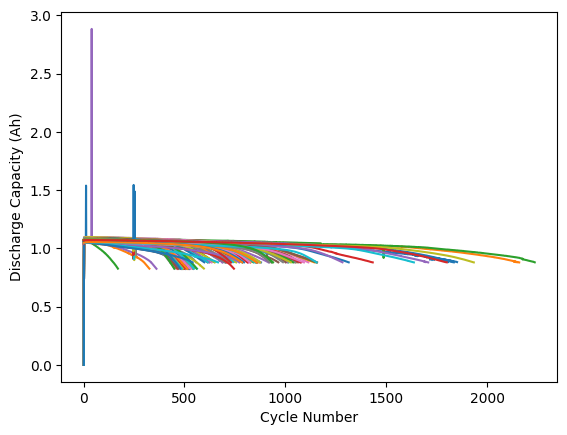

In [130]:
# Re-create figure 1a, Severson, et al.
for i in bat_dict.keys():
    plt.plot(bat_dict[i]['summary']['cycle'], bat_dict[i]['summary']['QD'])
plt.xlabel('Cycle Number')
plt.ylabel('Discharge Capacity (Ah)')

################################################################################

# Feature Engineering - Tabular data

 
The following code creates a Pandas dataframe with the tabular feature-set presented in Severson, et al.  Each feature is  listed in the following table (Table 1, Severson, et al.) And further described in Supplementary Note 1. (https://static-content.springer.com/esm/art%3A10.1038%2Fs41560-019-0356-8/MediaObjects/41560_2019_356_MOESM1_ESM.pdf) 

This is the summary of the first 100 cycles.

################################################################################



<div>
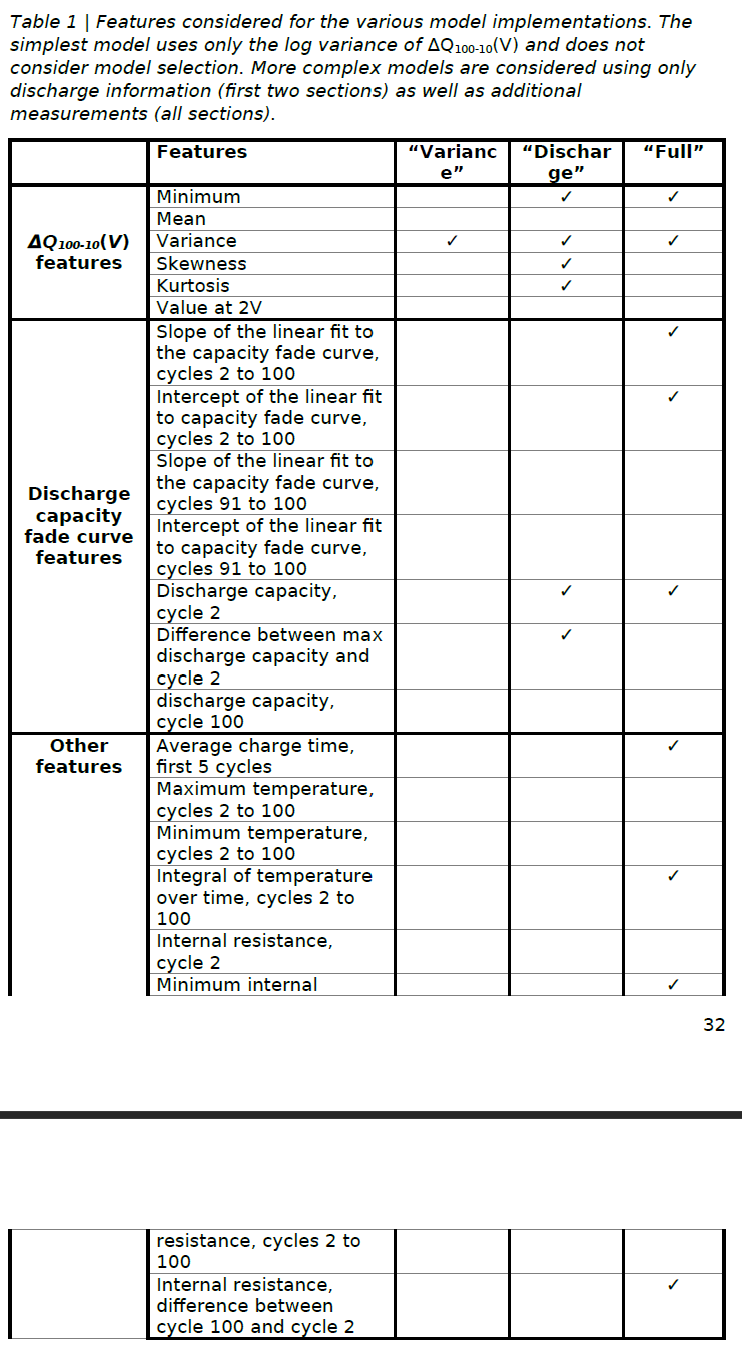
</div>


<div>
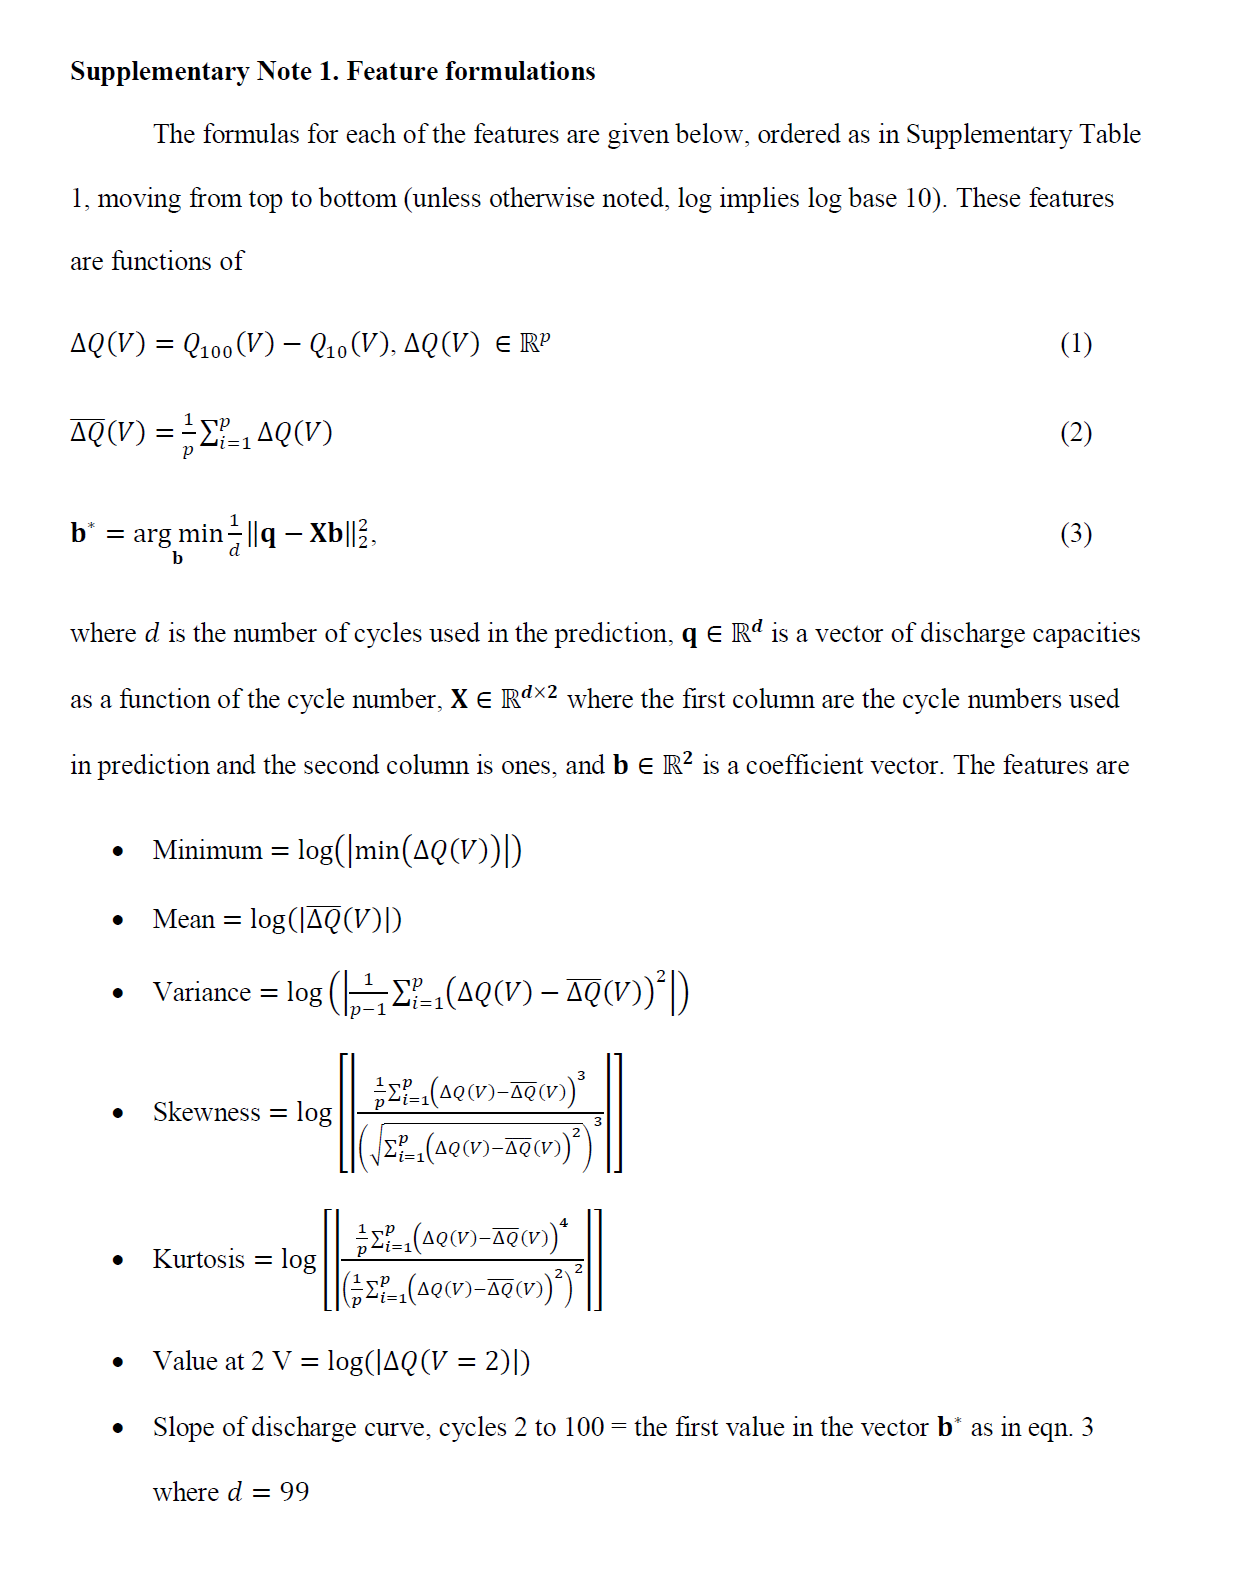
</div>


<div>
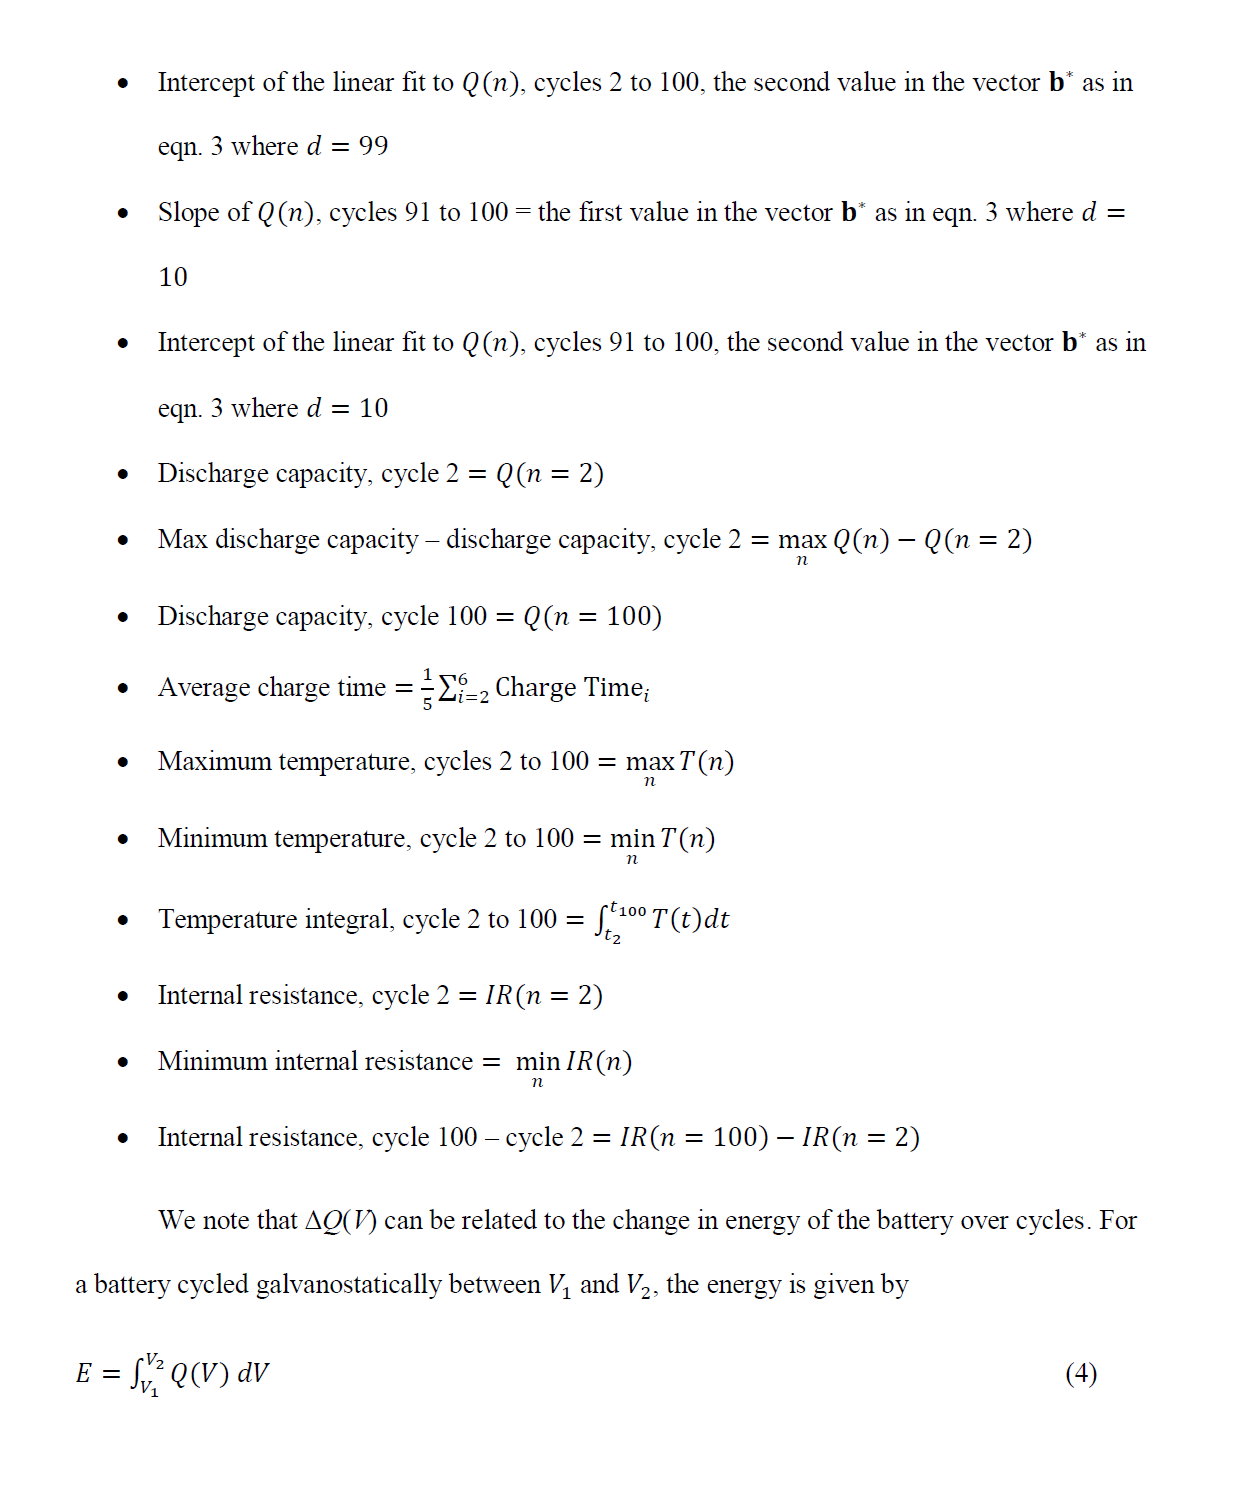
</div>

In [131]:
# Pandas Dataframe To hold all the features
dataset=pd.DataFrame()

# Battery cell Names from each battery dictionary
dataset['cell']=bat_dict.keys()

# cell_life = Number of cycles until battery reaches 80% capacity
# This is the target of the machine learning
############################################
cl=[]
for i in bat_dict.keys():
    cl.append(bat_dict[i]['cycle_life'][0][0])
dataset['cell_life']=cl
############################################

# Numpy arrays to hold Each feature
minimum_dQ_100_10 = np.zeros(len(bat_dict.keys()))
variance_dQ_100_10 = np.zeros(len(bat_dict.keys()))
skewness_dQ_100_10 = np.zeros(len(bat_dict.keys()))
kurtosis_dQ_100_10 = np.zeros(len(bat_dict.keys()))
mean_dQ_100_10 = np.zeros(len(bat_dict.keys()))
Slope_Cap_Fade_2_100=np.zeros(len(bat_dict.keys()))
Intercept_Cap_Fade_2_100=np.zeros(len(bat_dict.keys()))
Slope_Cap_Fade_91_100=np.zeros(len(bat_dict.keys()))
Intercept_Cap_Fade_91_100=np.zeros(len(bat_dict.keys()))
Discharge_Cap_2=np.zeros(len(bat_dict.keys()))
Discharge_Cap_100=np.zeros(len(bat_dict.keys()))
Diff_MaxCap_DC2=np.zeros(len(bat_dict.keys()))
Avg_charge_time=np.zeros(len(bat_dict.keys()))
Temp_Integ_2_100=np.zeros(len(bat_dict.keys()))
Min_IR=np.zeros(len(bat_dict.keys()))
Diff_IR_2_100=np.zeros(len(bat_dict.keys()))

In [132]:
# Loop through battery dictionary and create features for machine learning
for i, cell in enumerate(bat_dict.values()):
    c10 = cell['cycles']['9']#Corrected
    c100 = cell['cycles']['99']#Corrected
    dQ_100_10 = c100['Qdlin'] - c10['Qdlin']
    
    minimum_dQ_100_10[i] = np.log10(np.abs(np.min(dQ_100_10)))
    variance_dQ_100_10[i] = np.log10(np.var(dQ_100_10))
    skewness_dQ_100_10[i] = np.log10(np.abs(skew(dQ_100_10)))
    kurtosis_dQ_100_10[i] = np.log10(np.abs(kurtosis(dQ_100_10)))
    mean_dQ_100_10[i] = np.log10(np.abs(np.mean(dQ_100_10)))
    
    dqall=cell['summary']['QD']
    cap=cell['summary']['QD'][1:100].reshape(-1,1)
    cycle=cell['summary']['cycle'][1:100].reshape(-1,1)
    
    cap90=cell['summary']['QD'][90:100].reshape(-1,1)
    cycle90=cell['summary']['cycle'][90:100].reshape(-1,1)

    regressor=LinearRegression()
    regressor.fit(cycle,cap)
    Slope_Cap_Fade_2_100[i]=regressor.coef_[0]
    Intercept_Cap_Fade_2_100[i]=regressor.intercept_
    
    regressor90=LinearRegression()
    regressor90.fit(cycle90,cap90)
    Slope_Cap_Fade_91_100[i]=regressor90.coef_[0]
    Intercept_Cap_Fade_91_100[i]=regressor90.intercept_
    
    Discharge_Cap_2[i]=cap[0][0]
    Diff_MaxCap_DC2[i]=np.max(cap)-cap[0][0]
    Discharge_Cap_100[i]=cap[98][0] 
    
    avg_time=np.mean(cell['summary']['chargetime'][1:6])#Corrected
    a=cell['summary']['chargetime'][1:100]
    b=cell['summary']['Tavg'][1:100]
    integral=np.sum(np.multiply(a,b))
    array=cell['summary']['IR'][1:100]
    IR_min=min(array[array!=0])
    IR_diff=cell['summary']['IR'][99]-cell['summary']['IR'][1]
    
    Avg_charge_time[i]=avg_time
    Temp_Integ_2_100[i]=integral
    Min_IR[i]=IR_min
    Diff_IR_2_100[i]=IR_diff
    
    
# Insert numpy arrays into dataFrame
dataset['minimum_dQ_100_10']=minimum_dQ_100_10
dataset['variance_dQ_100_10']=variance_dQ_100_10 
dataset['skewness_dQ_100_10']=skewness_dQ_100_10 
dataset['kurtosis_dQ_100_10']=kurtosis_dQ_100_10 
dataset['mean_dQ_100_10']=mean_dQ_100_10 
dataset['Slope_Cap_Fade_2_100']=Slope_Cap_Fade_2_100
dataset['Intercept_Cap_Fade_2_100']=Intercept_Cap_Fade_2_100
dataset['Slope_Cap_Fade_91_100']=Slope_Cap_Fade_91_100
dataset['Intercept_Cap_Fade_91_100']=Intercept_Cap_Fade_91_100
dataset['Discharge_Cap_2']=Discharge_Cap_2
dataset['Discharge_Cap_100']=Discharge_Cap_100
dataset['Diff_MaxCap_DC2']=Diff_MaxCap_DC2
dataset['Avg_charge_time']=Avg_charge_time
dataset['Temp_Integ_2_100']=Temp_Integ_2_100
dataset['Min_IR']=Min_IR
dataset['Diff_IR_2_100']=Diff_IR_2_100 

In [133]:
# A set of Corrections applied By author
# https://www.dropbox.com/sh/rxeprl07xjj38sr/AABqO2uQQ5N3q4hcGyGPc_PAa?dl=0

import warnings
warnings.filterwarnings('ignore')

dataset['Diff_MaxCap_DC2'][0] = 0.0064
dataset['Slope_Cap_Fade_2_100'][0] = 1.692e-5
dataset['Intercept_Cap_Fade_2_100'][0] = 1.0750
dataset['Diff_MaxCap_DC2'][14] = 0.00397
dataset['Slope_Cap_Fade_2_100'][14] = -4.8296e-5
dataset['Intercept_Cap_Fade_2_100'][14] = 1.0705

In [134]:
dataset.corr()

,cell_life,minimum_dQ_100_10,variance_dQ_100_10,skewness_dQ_100_10,kurtosis_dQ_100_10,mean_dQ_100_10,Slope_Cap_Fade_2_100,Intercept_Cap_Fade_2_100,Slope_Cap_Fade_91_100,Intercept_Cap_Fade_91_100,Discharge_Cap_2,Discharge_Cap_100,Diff_MaxCap_DC2,Avg_charge_time,Temp_Integ_2_100,Min_IR,Diff_IR_2_100
cell_life,1.000000,-0.875441,-0.889743,0.276627,-0.296784,-0.871321,0.269596,-0.109816,0.310256,-0.218826,-0.044585,0.151356,-0.077080,0.563220,0.470067,-0.357034,0.182071
minimum_dQ_100_10,-0.875441,1.000000,0.996499,-0.250372,0.071009,0.992363,-0.462977,0.315235,-0.500431,0.459321,0.241220,-0.172987,-0.024055,-0.444605,-0.454846,0.355892,-0.196806
variance_dQ_100_10,-0.889743,0.996499,1.000000,-0.269032,0.125430,0.992486,-0.447759,0.298125,-0.482502,0.435466,0.226058,-0.171791,-0.027660,-0.463755,-0.461731,0.354960,-0.200748
skewness_dQ_100_10,0.276627,-0.250372,-0.269032,1.000000,-0.388069,-0.282916,-0.210520,-0.140557,-0.205353,-0.080745,-0.153927,-0.255392,-0.063357,0.266275,0.295870,-0.323991,0.068920
kurtosis_dQ_100_10,-0.296784,0.071009,0.125430,-0.388069,1.000000,0.098879,0.545869,0.089952,0.534683,-0.055013,0.117716,0.482562,0.258581,-0.170927,-0.135023,0.318547,0.034414
mean_dQ_100_10,-0.871321,0.992363,0.992486,-0.282916,0.098879,1.000000,-0.480543,0.301767,-0.512012,0.445238,0.233201,-0.193836,-0.089538,-0.473308,-0.468853,0.309971,-0.198111
Slope_Cap_Fade_2_100,0.269596,-0.462977,-0.447759,-0.210520,0.545869,-0.480543,1.000000,-0.015264,0.975740,-0.251964,0.065393,0.777370,0.400110,0.119927,0.107717,0.170255,0.242553
Intercept_Cap_Fade_2_100,-0.109816,0.315235,0.298125,-0.140557,0.089952,0.301767,-0.015264,1.000000,-0.018515,0.930677,0.989269,0.616230,0.227313,0.187415,-0.039908,0.419705,0.141092
Slope_Cap_Fade_91_100,0.310256,-0.500431,-0.482502,-0.205353,0.534683,-0.512012,0.975740,-0.018515,1.000000,-0.309771,0.074258,0.761925,0.315907,0.141618,0.141133,0.096101,0.258437
Intercept_Cap_Fade_91_100,-0.218826,0.459321,0.435466,-0.080745,-0.055013,0.445238,-0.251964,0.930677,-0.309771,1.000000,0.885940,0.379701,0.192561,0.111123,-0.109729,0.423316,0.052027


In [135]:
dataset

,cell,cell_life,minimum_dQ_100_10,variance_dQ_100_10,skewness_dQ_100_10,kurtosis_dQ_100_10,mean_dQ_100_10,Slope_Cap_Fade_2_100,Intercept_Cap_Fade_2_100,Slope_Cap_Fade_91_100,Intercept_Cap_Fade_91_100,Discharge_Cap_2,Discharge_Cap_100,Diff_MaxCap_DC2,Avg_charge_time,Temp_Integ_2_100,Min_IR,Diff_IR_2_100
0,b1c0,1852.0,-2.072648,-5.014861,-0.274041,0.129790,-2.541602,1.692000e-05,1.075000,0.000035,1.072425,1.070689,1.075913,0.006400,13.374894,41876.171150,0.016444,-0.000075
1,b1c1,2160.0,-1.958457,-5.013960,-0.367163,0.012464,-2.387257,5.535293e-06,1.080965,-0.000041,1.084767,1.075301,1.080630,0.009288,13.409150,41484.509937,0.016764,-0.000042
2,b1c2,2237.0,-1.764058,-4.737000,0.033502,-0.457627,-2.348070,1.029563e-05,1.084846,-0.000044,1.089364,1.079922,1.084940,0.008131,13.358242,41694.991899,0.016613,-0.000014
3,b1c3,1434.0,-1.722149,-4.442613,-0.357486,0.039579,-2.127507,1.713635e-05,1.084075,-0.000004,1.085131,1.079723,1.084750,0.006530,12.025140,35729.237342,0.016098,0.000039
4,b1c4,1709.0,-1.855177,-4.647744,-0.440634,0.125101,-2.240332,1.899432e-05,1.081875,-0.000029,1.085538,1.078417,1.082646,0.005900,12.041851,37527.249169,0.016369,-0.000053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,b3c39,1156.0,-1.758008,-4.454635,-0.533817,0.001307,-2.191895,-6.583238e-06,1.050919,-0.000024,1.052011,1.047404,1.049504,0.004107,10.043833,33692.718771,0.015481,-0.000155
120,b3c40,796.0,-1.656517,-4.295108,-0.501096,0.056338,-2.041969,-7.692147e-06,1.063392,-0.000048,1.066636,1.059324,1.061757,0.004510,10.043563,33860.417101,0.015255,-0.000234
121,b3c41,786.0,-1.616310,-4.219509,-0.447169,0.026586,-2.011082,9.732245e-06,1.053878,-0.000051,1.059149,1.050522,1.054153,0.004362,10.042974,33447.610799,0.017007,-0.000173
122,b3c44,940.0,-1.585275,-4.131496,-0.611514,0.092860,-1.949579,4.689737e-06,1.073078,-0.000018,1.074669,1.069720,1.072928,0.004185,10.043436,33160.813144,0.015517,-0.000106


In [136]:
################################################################################
################################################################################

# Final Tabular features and targets dataframe

#dataset.to_csv(r'data/TabularSummaryBatteryData.csv',na_rep='Unknown',float_format='%.6f',index=False)

################################################################################
################################################################################

################################################################################

# Feature Engineering - Tabular data

# Repeat using only the first 60 cycles

################################################################################


In [137]:
# Pandas Dataframe To hold all the features
dataset60=pd.DataFrame()

# Battery cell Names from each battery dictionary
dataset60['cell']=bat_dict.keys()

# cell_life = Number of cycles until battery reaches 80% capacity
# This is the target of the machine learning
############################################
cl=[]
for i in bat_dict.keys():
    cl.append(bat_dict[i]['cycle_life'][0][0])
dataset60['cell_life']=cl
############################################

# Numpy arrays to hold Each feature
minimum_dQ_60_10 = np.zeros(len(bat_dict.keys()))
variance_dQ_60_10 = np.zeros(len(bat_dict.keys()))
skewness_dQ_60_10 = np.zeros(len(bat_dict.keys()))
kurtosis_dQ_60_10 = np.zeros(len(bat_dict.keys()))
mean_dQ_60_10 = np.zeros(len(bat_dict.keys()))
Slope_Cap_Fade_2_60=np.zeros(len(bat_dict.keys()))
Intercept_Cap_Fade_2_60=np.zeros(len(bat_dict.keys()))
Slope_Cap_Fade_51_60=np.zeros(len(bat_dict.keys()))
Intercept_Cap_Fade_51_60=np.zeros(len(bat_dict.keys()))
Discharge_Cap_2=np.zeros(len(bat_dict.keys()))
Discharge_Cap_60=np.zeros(len(bat_dict.keys()))
Diff_MaxCap_DC2=np.zeros(len(bat_dict.keys()))
Avg_charge_time=np.zeros(len(bat_dict.keys()))
Temp_Integ_2_60=np.zeros(len(bat_dict.keys()))
Min_IR=np.zeros(len(bat_dict.keys()))
Diff_IR_2_60=np.zeros(len(bat_dict.keys()))

In [138]:
# Loop through battery dictionary and create features for machine learning
for i, cell in enumerate(bat_dict.values()):
    c10 = cell['cycles']['9']#Corrected
    c60 = cell['cycles']['59']#Corrected
    dQ_60_10 = c60['Qdlin'] - c10['Qdlin']
    
    minimum_dQ_60_10[i] = np.log10(np.abs(np.min(dQ_60_10)))
    variance_dQ_60_10[i] = np.log10(np.var(dQ_60_10))
    skewness_dQ_60_10[i] = np.log10(np.abs(skew(dQ_60_10)))
    kurtosis_dQ_60_10[i] = np.log10(np.abs(kurtosis(dQ_60_10)))
    mean_dQ_60_10[i] = np.log10(np.abs(np.mean(dQ_60_10)))
    
    dqall=cell['summary']['QD']
    cap=cell['summary']['QD'][1:60].reshape(-1,1)
    cycle=cell['summary']['cycle'][1:60].reshape(-1,1)
    
    cap50=cell['summary']['QD'][50:60].reshape(-1,1)
    cycle50=cell['summary']['cycle'][50:60].reshape(-1,1)

    regressor=LinearRegression()
    regressor.fit(cycle,cap)
    Slope_Cap_Fade_2_60[i]=regressor.coef_[0]
    Intercept_Cap_Fade_2_60[i]=regressor.intercept_
    
    regressor50=LinearRegression()
    regressor50.fit(cycle50,cap50)
    Slope_Cap_Fade_51_60[i]=regressor50.coef_[0]
    Intercept_Cap_Fade_51_60[i]=regressor50.intercept_
    
    Discharge_Cap_2[i]=cap[0][0]
    Diff_MaxCap_DC2[i]=np.max(cap)-cap[0][0]
    Discharge_Cap_60[i]=cap[58][0] 
    
    avg_time=np.mean(cell['summary']['chargetime'][1:6])#Corrected
    a=cell['summary']['chargetime'][1:60]
    b=cell['summary']['Tavg'][1:60]
    integral=np.sum(np.multiply(a,b))
    array=cell['summary']['IR'][1:60]
    IR_min=min(array[array!=0])
    IR_diff=cell['summary']['IR'][59]-cell['summary']['IR'][1]
    
    Avg_charge_time[i]=avg_time
    Temp_Integ_2_60[i]=integral
    Min_IR[i]=IR_min
    Diff_IR_2_60[i]=IR_diff
    
    
# Insert numpy arrays into dataFrame
dataset60['minimum_dQ_60_10']=minimum_dQ_60_10
dataset60['variance_dQ_60_10']=variance_dQ_60_10 
dataset60['skewness_dQ_60_10']=skewness_dQ_60_10 
dataset60['kurtosis_dQ_60_10']=kurtosis_dQ_60_10 
dataset60['mean_dQ_60_10']=mean_dQ_60_10 
dataset60['Slope_Cap_Fade_2_60']=Slope_Cap_Fade_2_60
dataset60['Intercept_Cap_Fade_2_60']=Intercept_Cap_Fade_2_60
dataset60['Slope_Cap_Fade_51_60']=Slope_Cap_Fade_51_60
dataset60['Intercept_Cap_Fade_51_60']=Intercept_Cap_Fade_51_60
dataset60['Discharge_Cap_2']=Discharge_Cap_2
dataset60['Discharge_Cap_60']=Discharge_Cap_60
dataset60['Diff_MaxCap_DC2']=Diff_MaxCap_DC2
dataset60['Avg_charge_time']=Avg_charge_time
dataset60['Temp_Integ_2_60']=Temp_Integ_2_60
dataset60['Min_IR']=Min_IR
dataset60['Diff_IR_2_60']=Diff_IR_2_60

In [139]:
# A set of Corrections applied By author
# https://www.dropbox.com/sh/rxeprl07xjj38sr/AABqO2uQQ5N3q4hcGyGPc_PAa?dl=0

import warnings
warnings.filterwarnings('ignore')

dataset60['Diff_MaxCap_DC2'][0] = 0.0064
dataset60['Slope_Cap_Fade_2_60'][0] = 1.692e-5
dataset60['Intercept_Cap_Fade_2_60'][0] = 1.0750
dataset60['Diff_MaxCap_DC2'][14] = 0.00397
dataset60['Slope_Cap_Fade_2_60'][14] = -4.8296e-5
dataset60['Intercept_Cap_Fade_2_60'][14] = 1.0705

In [140]:
################################################################################
################################################################################

# Final Tabular features and targets dataframe

#dataset60.to_csv(r'data/TabularSummaryBatteryData-60Cycles.csv',na_rep='Unknown',float_format='%.6f',index=False)

################################################################################
################################################################################

################################################################################

# Feature Engineering - Tabular data

# Repeat using only the first 40 cycles

################################################################################


In [141]:
# Pandas Dataframe To hold all the features
dataset40=pd.DataFrame()

# Battery cell Names from each battery dictionary
dataset40['cell']=bat_dict.keys()

# cell_life = Number of cycles until battery reaches 80% capacity
# This is the target of the machine learning
############################################
cl=[]
for i in bat_dict.keys():
    cl.append(bat_dict[i]['cycle_life'][0][0])
dataset40['cell_life']=cl
############################################

# Numpy arrays to hold Each feature
minimum_dQ_40_10 = np.zeros(len(bat_dict.keys()))
variance_dQ_40_10 = np.zeros(len(bat_dict.keys()))
skewness_dQ_40_10 = np.zeros(len(bat_dict.keys()))
kurtosis_dQ_40_10 = np.zeros(len(bat_dict.keys()))
mean_dQ_40_10 = np.zeros(len(bat_dict.keys()))
Slope_Cap_Fade_2_40=np.zeros(len(bat_dict.keys()))
Intercept_Cap_Fade_2_40=np.zeros(len(bat_dict.keys()))
Slope_Cap_Fade_31_40=np.zeros(len(bat_dict.keys()))
Intercept_Cap_Fade_31_40=np.zeros(len(bat_dict.keys()))
Discharge_Cap_2=np.zeros(len(bat_dict.keys()))
Discharge_Cap_40=np.zeros(len(bat_dict.keys()))
Diff_MaxCap_DC2=np.zeros(len(bat_dict.keys()))
Avg_charge_time=np.zeros(len(bat_dict.keys()))
Temp_Integ_2_40=np.zeros(len(bat_dict.keys()))
Min_IR=np.zeros(len(bat_dict.keys()))
Diff_IR_2_40=np.zeros(len(bat_dict.keys()))

In [142]:
# Loop through battery dictionary and create features for machine learning
for i, cell in enumerate(bat_dict.values()):
    c10 = cell['cycles']['9']#Corrected
    c40 = cell['cycles']['39']#Corrected
    dQ_40_10 = c40['Qdlin'] - c10['Qdlin']
    
    minimum_dQ_40_10[i] = np.log10(np.abs(np.min(dQ_40_10)))
    variance_dQ_40_10[i] = np.log10(np.var(dQ_40_10))
    skewness_dQ_40_10[i] = np.log10(np.abs(skew(dQ_40_10)))
    kurtosis_dQ_40_10[i] = np.log10(np.abs(kurtosis(dQ_40_10)))
    mean_dQ_40_10[i] = np.log10(np.abs(np.mean(dQ_40_10)))
    
    dqall=cell['summary']['QD']
    cap=cell['summary']['QD'][1:40].reshape(-1,1)
    cycle=cell['summary']['cycle'][1:40].reshape(-1,1)
    
    cap30=cell['summary']['QD'][30:40].reshape(-1,1)
    cycle30=cell['summary']['cycle'][30:40].reshape(-1,1)

    regressor=LinearRegression()
    regressor.fit(cycle,cap)
    Slope_Cap_Fade_2_40[i]=regressor.coef_[0]
    Intercept_Cap_Fade_2_40[i]=regressor.intercept_
    
    regressor30=LinearRegression()
    regressor30.fit(cycle30,cap30)
    Slope_Cap_Fade_31_40[i]=regressor30.coef_[0]
    Intercept_Cap_Fade_31_40[i]=regressor30.intercept_
    
    Discharge_Cap_2[i]=cap[0][0]
    Diff_MaxCap_DC2[i]=np.max(cap)-cap[0][0]
    Discharge_Cap_40[i]=cap[38][0] 
    
    avg_time=np.mean(cell['summary']['chargetime'][1:6])#Corrected
    a=cell['summary']['chargetime'][1:40]
    b=cell['summary']['Tavg'][1:40]
    integral=np.sum(np.multiply(a,b))
    array=cell['summary']['IR'][1:40]
    IR_min=min(array[array!=0])
    IR_diff=cell['summary']['IR'][39]-cell['summary']['IR'][1]
    
    Avg_charge_time[i]=avg_time
    Temp_Integ_2_40[i]=integral
    Min_IR[i]=IR_min
    Diff_IR_2_40[i]=IR_diff
    
    
# Insert numpy arrays into dataFrame
dataset40['minimum_dQ_40_10']=minimum_dQ_40_10
dataset40['variance_dQ_40_10']=variance_dQ_40_10 
dataset40['skewness_dQ_40_10']=skewness_dQ_40_10 
dataset40['kurtosis_dQ_40_10']=kurtosis_dQ_40_10 
dataset40['mean_dQ_40_10']=mean_dQ_40_10 
dataset40['Slope_Cap_Fade_2_40']=Slope_Cap_Fade_2_40
dataset40['Intercept_Cap_Fade_2_40']=Intercept_Cap_Fade_2_40
dataset40['Slope_Cap_Fade_31_40']=Slope_Cap_Fade_31_40
dataset40['Intercept_Cap_Fade_31_40']=Intercept_Cap_Fade_31_40
dataset40['Discharge_Cap_2']=Discharge_Cap_2
dataset40['Discharge_Cap_40']=Discharge_Cap_40
dataset40['Diff_MaxCap_DC2']=Diff_MaxCap_DC2
dataset40['Avg_charge_time']=Avg_charge_time
dataset40['Temp_Integ_2_40']=Temp_Integ_2_40
dataset40['Min_IR']=Min_IR
dataset40['Diff_IR_2_40']=Diff_IR_2_40

In [143]:
# A set of Corrections applied By author
# https://www.dropbox.com/sh/rxeprl07xjj38sr/AABqO2uQQ5N3q4hcGyGPc_PAa?dl=0

import warnings
warnings.filterwarnings('ignore')

dataset40['Diff_MaxCap_DC2'][0] = 0.0064
dataset40['Slope_Cap_Fade_2_40'][0] = 1.692e-5
dataset40['Intercept_Cap_Fade_2_40'][0] = 1.0750
dataset40['Diff_MaxCap_DC2'][14] = 0.00397
dataset40['Slope_Cap_Fade_2_40'][14] = -4.8296e-5
dataset40['Intercept_Cap_Fade_2_40'][14] = 1.0705

In [144]:
################################################################################
################################################################################

# Final Tabular features and targets dataframe

#dataset40.to_csv(r'data/TabularSummaryBatteryData-40Cycles.csv',na_rep='Unknown',float_format='%.6f',index=False)

################################################################################
################################################################################

################################################################################

# Feature Engineering - Tabular data

# Repeat using only the first 20 cycles

################################################################################


In [145]:
# Pandas Dataframe To hold all the features
dataset20=pd.DataFrame()

# Battery cell Names from each battery dictionary
dataset20['cell']=bat_dict.keys()

# cell_life = Number of cycles until battery reaches 80% capacity
# This is the target of the machine learning
############################################
cl=[]
for i in bat_dict.keys():
    cl.append(bat_dict[i]['cycle_life'][0][0])
dataset20['cell_life']=cl
############################################

# Numpy arrays to hold Each feature
minimum_dQ_20_10 = np.zeros(len(bat_dict.keys()))
variance_dQ_20_10 = np.zeros(len(bat_dict.keys()))
skewness_dQ_20_10 = np.zeros(len(bat_dict.keys()))
kurtosis_dQ_20_10 = np.zeros(len(bat_dict.keys()))
mean_dQ_20_10 = np.zeros(len(bat_dict.keys()))
Slope_Cap_Fade_2_20=np.zeros(len(bat_dict.keys()))
Intercept_Cap_Fade_2_20=np.zeros(len(bat_dict.keys()))
Slope_Cap_Fade_11_20=np.zeros(len(bat_dict.keys()))
Intercept_Cap_Fade_11_20=np.zeros(len(bat_dict.keys()))
Discharge_Cap_2=np.zeros(len(bat_dict.keys()))
Discharge_Cap_20=np.zeros(len(bat_dict.keys()))
Diff_MaxCap_DC2=np.zeros(len(bat_dict.keys()))
Avg_charge_time=np.zeros(len(bat_dict.keys()))
Temp_Integ_2_20=np.zeros(len(bat_dict.keys()))
Min_IR=np.zeros(len(bat_dict.keys()))
Diff_IR_2_20=np.zeros(len(bat_dict.keys()))

In [146]:
# Loop through battery dictionary and create features for machine learning
for i, cell in enumerate(bat_dict.values()):
    c10 = cell['cycles']['9']#Corrected
    c20 = cell['cycles']['19']#Corrected
    dQ_20_10 = c60['Qdlin'] - c10['Qdlin']
    
    minimum_dQ_20_10[i] = np.log10(np.abs(np.min(dQ_60_10)))
    variance_dQ_20_10[i] = np.log10(np.var(dQ_60_10))
    skewness_dQ_20_10[i] = np.log10(np.abs(skew(dQ_60_10)))
    kurtosis_dQ_20_10[i] = np.log10(np.abs(kurtosis(dQ_60_10)))
    mean_dQ_20_10[i] = np.log10(np.abs(np.mean(dQ_60_10)))
    
    dqall=cell['summary']['QD']
    cap=cell['summary']['QD'][1:20].reshape(-1,1)
    cycle=cell['summary']['cycle'][1:20].reshape(-1,1)
    
    cap10=cell['summary']['QD'][10:20].reshape(-1,1)
    cycle10=cell['summary']['cycle'][10:20].reshape(-1,1)

    regressor=LinearRegression()
    regressor.fit(cycle,cap)
    Slope_Cap_Fade_2_20[i]=regressor.coef_[0]
    Intercept_Cap_Fade_2_20[i]=regressor.intercept_
    
    regressor10=LinearRegression()
    regressor10.fit(cycle10,cap10)
    Slope_Cap_Fade_11_20[i]=regressor10.coef_[0]
    Intercept_Cap_Fade_11_20[i]=regressor10.intercept_
    
    Discharge_Cap_2[i]=cap[0][0]
    Diff_MaxCap_DC2[i]=np.max(cap)-cap[0][0]
    Discharge_Cap_20[i]=cap[18][0] 
    
    avg_time=np.mean(cell['summary']['chargetime'][1:6])#Corrected
    a=cell['summary']['chargetime'][1:20]
    b=cell['summary']['Tavg'][1:20]
    integral=np.sum(np.multiply(a,b))
    array=cell['summary']['IR'][1:20]
    IR_min=min(array[array!=0])
    IR_diff=cell['summary']['IR'][19]-cell['summary']['IR'][1]
    
    Avg_charge_time[i]=avg_time
    Temp_Integ_2_20[i]=integral
    Min_IR[i]=IR_min
    Diff_IR_2_20[i]=IR_diff
    
    
# Insert numpy arrays into dataFrame
dataset20['minimum_dQ_20_10']=minimum_dQ_20_10
dataset20['variance_dQ_20_10']=variance_dQ_20_10
dataset20['skewness_dQ_20_10']=skewness_dQ_20_10
dataset20['kurtosis_dQ_20_10']=kurtosis_dQ_20_10
dataset20['mean_dQ_20_10']=mean_dQ_20_10
dataset20['Slope_Cap_Fade_2_20']=Slope_Cap_Fade_2_20
dataset20['Intercept_Cap_Fade_2_20']=Intercept_Cap_Fade_2_20
dataset20['Slope_Cap_Fade_11_20']=Slope_Cap_Fade_11_20
dataset20['Intercept_Cap_Fade_11_20']=Intercept_Cap_Fade_11_20
dataset20['Discharge_Cap_2']=Discharge_Cap_2
dataset20['Discharge_Cap_20']=Discharge_Cap_20
dataset20['Diff_MaxCap_DC2']=Diff_MaxCap_DC2
dataset20['Avg_charge_time']=Avg_charge_time
dataset20['Temp_Integ_2_20']=Temp_Integ_2_20
dataset20['Min_IR']=Min_IR
dataset20['Diff_IR_2_20']=Diff_IR_2_20

In [147]:
# A set of Corrections applied By author
# https://www.dropbox.com/sh/rxeprl07xjj38sr/AABqO2uQQ5N3q4hcGyGPc_PAa?dl=0

import warnings
warnings.filterwarnings('ignore')

dataset20['Diff_MaxCap_DC2'][0] = 0.0064
dataset20['Slope_Cap_Fade_2_20'][0] = 1.692e-5
dataset20['Intercept_Cap_Fade_2_20'][0] = 1.0750
dataset20['Diff_MaxCap_DC2'][14] = 0.00397
dataset20['Slope_Cap_Fade_2_20'][14] = -4.8296e-5
dataset20['Intercept_Cap_Fade_2_20'][14] = 1.0705

In [148]:
################################################################################
################################################################################

# Final Tabular features and targets dataframe

#dataset20.to_csv(r'data/TabularSummaryBatteryData-20Cycles.csv',na_rep='Unknown',float_format='%.6f',index=False)

################################################################################
################################################################################

################################################################################

# Feature Engineering - Discharge capacity data

 
The following code creates and saves 3 Pytorch Tensors from the linearly interpolated discharge capacity values (labeled 'Qdlin' in the Battery dictionary provided by Severson, et al.)


Train - 41 batties X 99 cycles X 100 Linearly interpolated discharge capacity values

Test - 42 batties X 99 cycles X 100 Linearly interpolated discharge capacity values

Test-Secondary - 40 batties X 99 cycles X 100 Linearly interpolated discharge capacity values


################################################################################


In [149]:
import torch
torch.manual_seed(0)

Vdlin = f[batch['Vdlin'][0,0]][()][0]
Cycles = np.linspace(0,99,99)

In [150]:
# List of battery names (key values of bat_dict)
cell_names = np.array(list(bat_dict.keys()))

# Split batteries by test/train splits consistent with Severson, et al.
train_names = cell_names[train_ind]
test_names = cell_names[test_edited_ind]
secondary_test_names = cell_names[secondary_test_ind]

In [151]:
# Create empty arrays to hold Qdlin data
train_Qdlin=[]
test_Qdlin=[]
secondary_test_Qdlin=[]
split_arrays = [train_Qdlin,test_Qdlin,secondary_test_Qdlin]

splits=[train_ind ,test_edited_ind ,secondary_test_ind]
for split,split_array in zip(splits,split_arrays):
    for cell_ind in split:
        cell_Qdlin=[] # Qdlin Capacity values for each battery cell
        cell_name = cell_names[cell_ind]
        for cycle in range(1,100): # 100 Q(V) Capacity values for 1st 100 cycles
            
            # Appends Qdlin arrays directly from battery dictionary
            # 1000 linearly interpolated values for each cycle
            # First 100 cycles, For each battery, For each Train/Test split
            cell_Qdlin.append(bat_dict[cell_name]['cycles'][str(cycle)]['Qdlin'])
        split_array.append(cell_Qdlin)
        
train_Qdlin = np.array(train_Qdlin)
test_Qdlin = np.array(test_Qdlin)
secondary_test_Qdlin = np.array(secondary_test_Qdlin)

print(train_Qdlin.shape)
print(test_Qdlin.shape)
print(secondary_test_Qdlin.shape)

(41, 99, 1000)
(42, 99, 1000)
(40, 99, 1000)


# Corrections

There are a handful of cycles with bad Qdlin, as you can see in the graphs below. This simply sets the noisy cycles equal to the previous cycle.

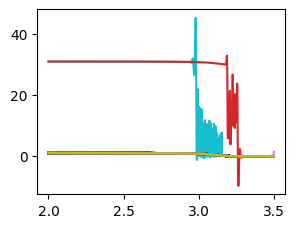

In [152]:
# Graph of all Qdlin in training set 
plt.figure(figsize=(3.2,2.4))
for bat in range(41):
    for cycle in range(99):
        plt.plot(Vdlin, train_Qdlin[bat][cycle])
plt.show()

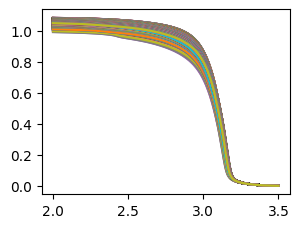

In [153]:
# Qdlin Corrections in training set
# Noisy cycles are replaced with previous cycle
train_Qdlin[8][11] = train_Qdlin[8][10]
train_Qdlin[1][10] = train_Qdlin[1][9]
train_Qdlin[15][71] = train_Qdlin[15][70]

plt.figure(figsize=(3.2,2.4))
for bat in range(41):
    for cycle in range(99):
        plt.plot(Vdlin, train_Qdlin[bat][cycle])
plt.show()
#Nice and smooth curve

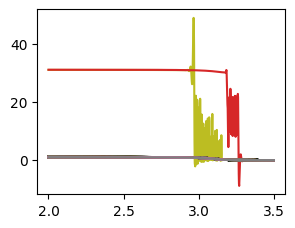

In [154]:
# Test set
plt.figure(figsize=(3.2,2.4))
for bat in range(42):
    for cycle in range(99):
        plt.plot(Vdlin, test_Qdlin[bat][cycle])
plt.show()

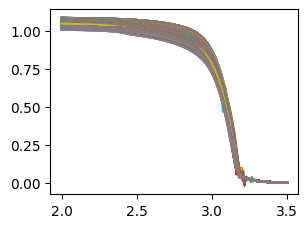

In [155]:
test_Qdlin[2][10] = test_Qdlin[2][9]
test_Qdlin[8][11] = test_Qdlin[8][10]
test_Qdlin[37][72] = test_Qdlin[37][71]
test_Qdlin[37][73] = test_Qdlin[37][71]
test_Qdlin[0][10] = test_Qdlin[0][9]

plt.figure(figsize=(3.2,2.4))
for bat in range(42):
    for cycle in range(99):
        plt.plot(Vdlin, test_Qdlin[bat][cycle])
plt.show()

Secondary test set

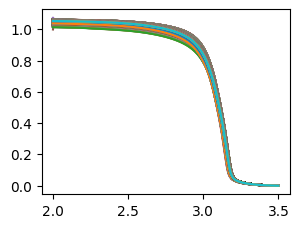

In [156]:
plt.figure(figsize=(3.2,2.4))
for bat in range(40):
    for cycle in range(99):
        plt.plot(Vdlin, secondary_test_Qdlin[bat][cycle])
plt.show()

# Scale and save

Scale and resize to create a Discharge-capacity matrix of size 100 X 99, for each battery.

In [157]:
print(train_Qdlin.shape)
print(test_Qdlin.shape)
print(secondary_test_Qdlin.shape)

# Scale the same as the Attia et al. 
# https://github.com/petermattia/revisit-severson-et-al/blob/main/nn_models/cnn_base.py
train_Qdlin = train_Qdlin[:, :, :] - train_Qdlin[:,  8, :][:, np.newaxis,:]
test_Qdlin = test_Qdlin[:, :, :] - test_Qdlin[:, 8, :][:, np.newaxis,:]
secondary_test_Qdlin = secondary_test_Qdlin[:, :, :] - secondary_test_Qdlin[:,  8, :][:, np.newaxis,:]

(41, 99, 1000)
(42, 99, 1000)
(40, 99, 1000)


In [158]:
#Switch the 2nd and 3rd axis
train_Qdlin = torch.permute(torch.from_numpy(train_Qdlin), (0, 2, 1))
test_Qdlin = torch.permute(torch.from_numpy(test_Qdlin), (0, 2, 1))
secondary_test_Qdlin = torch.permute(torch.from_numpy(secondary_test_Qdlin), (0, 2, 1))

#Reduce the size of the data, for computational efficiency
train_Qdlin = train_Qdlin[:,::10,:]
test_Qdlin = test_Qdlin[:,::10,:]
secondary_test_Qdlin = secondary_test_Qdlin[:,::10,:]

print(train_Qdlin.shape)
print(test_Qdlin.shape)
print(secondary_test_Qdlin.shape)

torch.Size([41, 100, 99])
torch.Size([42, 100, 99])
torch.Size([40, 100, 99])


In [159]:
#Normalize standard deviation
stdev = train_Qdlin.std()
train_Qdlin = (train_Qdlin) / stdev
test_Qdlin = (test_Qdlin) / stdev
secondary_test_Qdlin = (secondary_test_Qdlin) / stdev

print(train_Qdlin.std(),train_Qdlin.mean())
print(test_Qdlin.std(),test_Qdlin.mean())
print(secondary_test_Qdlin.std(),secondary_test_Qdlin.mean())

tensor(1.0000, dtype=torch.float64) tensor(-0.6982, dtype=torch.float64)
tensor(0.8786, dtype=torch.float64) tensor(-0.6188, dtype=torch.float64)
tensor(0.4862, dtype=torch.float64) tensor(-0.3183, dtype=torch.float64)


In [160]:
# torch.save(train_Qdlin, r'data/DischargeCapacity-InterpolatedData_Train.pt')
# torch.save(test_Qdlin, r'data/DischargeCapacity-InterpolatedData_Test.pt')
# torch.save(secondary_test_Qdlin, r'data/DischargeCapacity-InterpolatedData_Secondary_Test.pt')

# Some data visualization

In [161]:
bat_dict['b1c0']['cycles']['99']['t']

array([0.00000000e+00, 2.45833333e-03, 2.87166667e-03, ...,
       5.43575650e+01, 5.43669383e+01, 5.43743417e+01])

In [162]:
bat_dict['b1c0']['cycles']['99']['Qd'].shape

(1100,)

Text(0, 0.5, 'Discharge Capacity (Ah)')

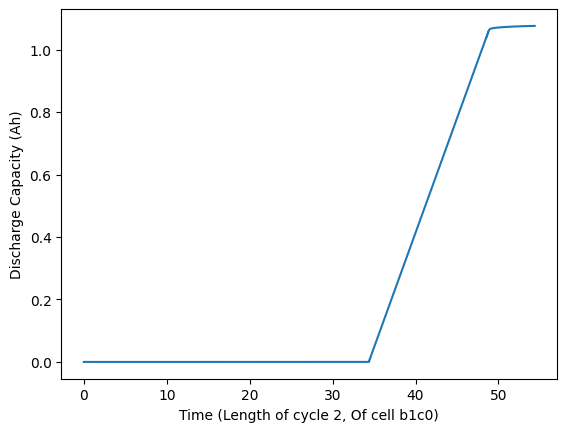

In [163]:
# Qd Plot of cycle #1, battery cell 'b1c0'
plt.plot(bat_dict['b1c0']['cycles']['99']['t'], bat_dict['b1c0']['cycles']['99']['Qd'])
plt.xlabel('Time (Length of cycle 2, Of cell b1c0)')
plt.ylabel('Discharge Capacity (Ah)')

Text(0, 0.5, 'dQdV')

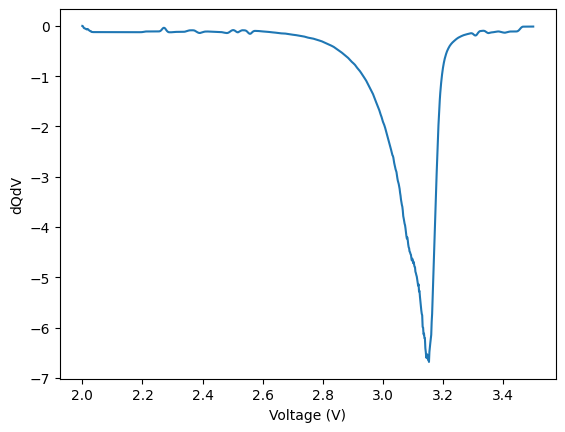

In [164]:

# Qd Plot of cycle #1, battery cell 'b1c0'
plt.plot(Vdlin, bat_dict['b1c0']['cycles']['1']['dQdV'])
plt.xlabel('Voltage (V)')
plt.ylabel('dQdV')

Text(0, 0.5, 'Discharge Capacity (Ah)')

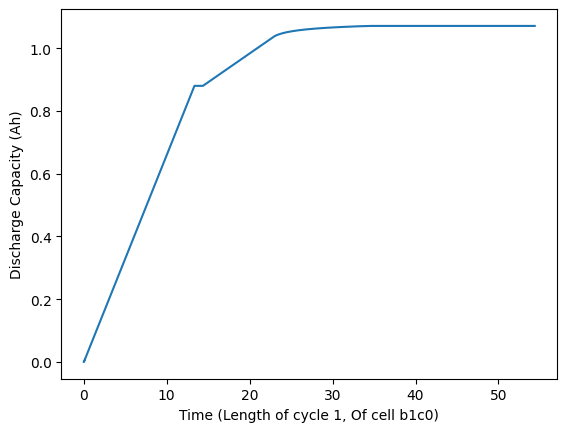

In [165]:
# Qd Plot of cycle #1, battery cell 'b1c0'
plt.plot(bat_dict['b1c0']['cycles']['1']['t'], bat_dict['b1c0']['cycles']['1']['Qc'])
plt.xlabel('Time (Length of cycle 1, Of cell b1c0)')
plt.ylabel('Discharge Capacity (Ah)')

Text(0, 0.5, 'Discharge Capacity (Ah)')

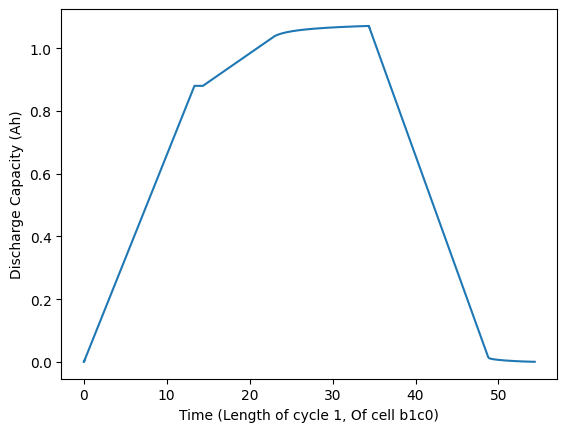

In [166]:
 # Qd Plot of cycle #1, battery cell 'b1c0'
plt.plot(bat_dict['b1c0']['cycles']['1']['t'], (bat_dict['b1c0']['cycles']['1']['Qc']- bat_dict['b1c0']['cycles']['1']['Qd']))
plt.xlabel('Time (Length of cycle 1, Of cell b1c0)')
plt.ylabel('Discharge Capacity (Ah)')

Text(0, 0.5, 'Current (A)')

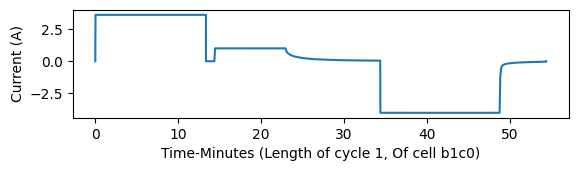

In [167]:
plt.figure(figsize=(6.4,1.4))
# I Plot of cycle #1, battery cell 'b1c0'
#plt.title('Current (A)')
plt.plot(bat_dict['b1c0']['cycles']['1']['t'], bat_dict['b1c0']['cycles']['1']['I'])
plt.xlabel('Time-Minutes (Length of cycle 1, Of cell b1c0)')
plt.ylabel('Current (A)')

Text(0, 0.5, 'Voltage (V)')

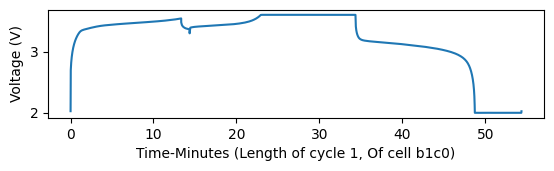

In [168]:
plt.figure(figsize=(6.4,1.4))
# I Plot of cycle #1, battery cell 'b1c0'
plt.plot(bat_dict['b1c0']['cycles']['1']['t'], bat_dict['b1c0']['cycles']['1']['V'])
plt.xlabel('Time-Minutes (Length of cycle 1, Of cell b1c0)')
plt.ylabel('Voltage (V)')

Text(0, 0.5, 'Temperature-Celsius')

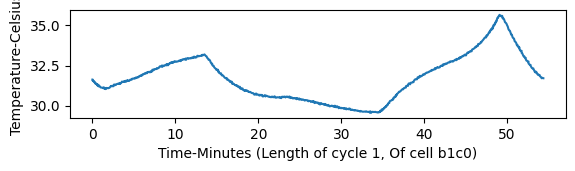

In [169]:
plt.figure(figsize=(6.4,1.4))
# I Plot of cycle #1, battery cell 'b1c0'
plt.plot(bat_dict['b1c0']['cycles']['1']['t'], bat_dict['b1c0']['cycles']['1']['T'])
plt.xlabel('Time-Minutes (Length of cycle 1, Of cell b1c0)')
plt.ylabel('Temperature-Celsius')

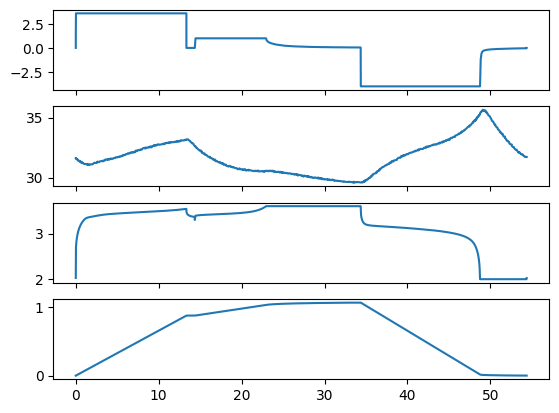

In [170]:
# Two subplots, the axes array is 1-d
f, axarr = plt.subplots(4, sharex=True)
#axarr[0].set_title('Sharing X axis')
axarr[0].plot(bat_dict['b1c0']['cycles']['1']['t'], bat_dict['b1c0']['cycles']['1']['I'])
#axarr[0].set_ylabel('Current (A)')
axarr[1].plot(bat_dict['b1c0']['cycles']['1']['t'], bat_dict['b1c0']['cycles']['1']['T'])
#axarr[1].set_ylabel('Temp')
axarr[2].plot(bat_dict['b1c0']['cycles']['1']['t'], bat_dict['b1c0']['cycles']['1']['V'])
#axarr[2].set_ylabel('V')
axarr[3].plot(bat_dict['b1c0']['cycles']['1']['t'], (bat_dict['b1c0']['cycles']['1']['Qc']- bat_dict['b1c0']['cycles']['1']['Qd']))
#axarr[3].set_ylabel('Discharge Capacity (Ah)')



Text(0, 0.5, 'Discharge Capacity (Ah)')

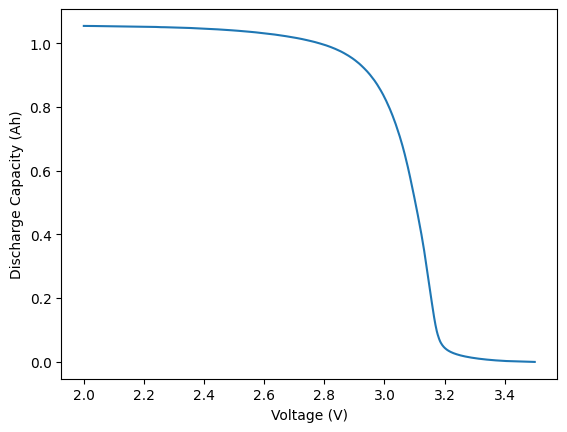

In [171]:
# ['I', 'Qc', 'Qd', 'Qdlin', 'T', 'Tdlin', 'V', 'dQdV', 't']
plt.plot(Vdlin, bat_dict['b1c0']['cycles']['1']['Qdlin'])
plt.xlabel('Voltage (V)')
plt.ylabel('Discharge Capacity (Ah)')

Text(0, 0.5, 'Temperature-Celsius')

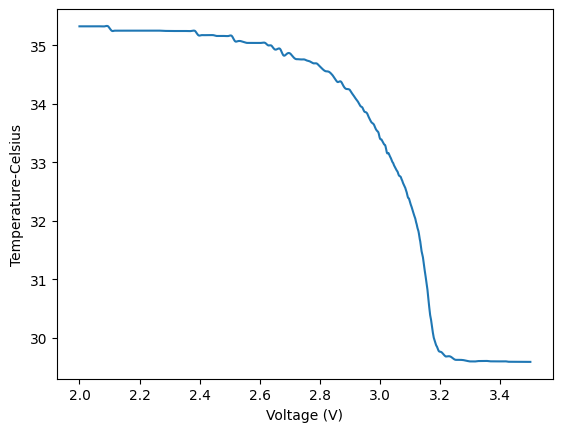

In [172]:
# ['I', 'Qc', 'Qd', 'Qdlin', 'T', 'Tdlin', 'V', 'dQdV', 't']
plt.plot(Vdlin, bat_dict['b1c0']['cycles']['1']['Tdlin'])
plt.xlabel('Voltage (V)')
plt.ylabel('Temperature-Celsius')

Qdlin

b1c1
2160.0


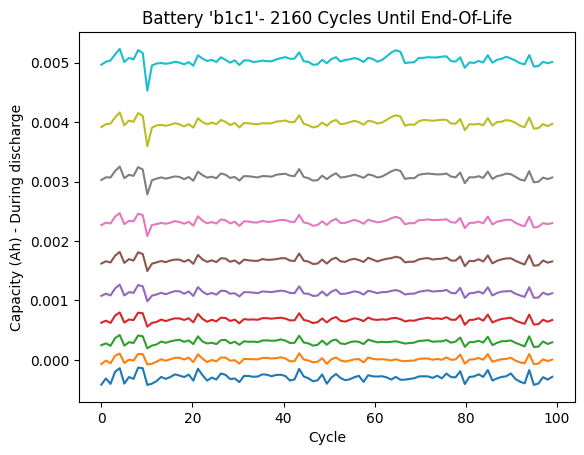

b2c4
444.0


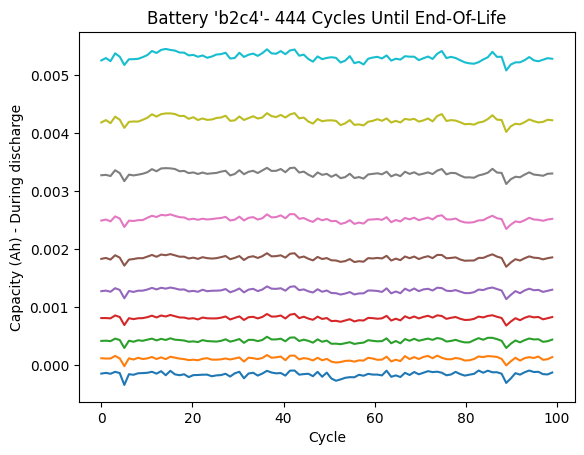

In [173]:
#print(dataset['cell_life'][train_ind])
print(train_names[0])
print(bat_dict['b1c1']['cycle_life'][0][0])
for Voltage in range(1, 100, 10):
    Qdlins = []
    #plt.figure(figsize=(3.2,2.4))
    for cycle in range(1, 100):
        Qdlins.append(bat_dict['b1c1']['cycles'][str(cycle)]['Qdlin'][Voltage])
    plt.plot(Cycles, Qdlins)
plt.title("Battery 'b1c1'- 2160 Cycles Until End-Of-Life")
plt.xlabel('Cycle')
plt.ylabel('Capacity (Ah) - During discharge')
plt.show()

#print(dataset['cell_life'][train_ind])
print(train_names[22])
print(bat_dict['b2c4']['cycle_life'][0][0])
for Voltage in range(1, 100, 10):
    Qdlins = []
    #plt.figure(figsize=(3.2,2.4))
    for cycle in range(1, 100):
        Qdlins.append(bat_dict['b2c4']['cycles'][str(cycle)]['Qdlin'][Voltage])
    plt.plot(Cycles, Qdlins)
plt.title("Battery 'b2c4'- 444 Cycles Until End-Of-Life")
plt.xlabel('Cycle')
plt.ylabel('Capacity (Ah) - During discharge')
plt.show()

b1c1
2160.0


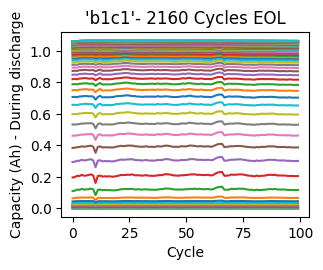

b2c4
444.0


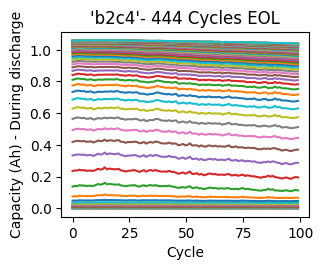

In [186]:
#print(dataset['cell_life'][train_ind])
print(train_names[0])
print(bat_dict['b1c1']['cycle_life'][0][0])
plt.figure(figsize=(3.2,2.4))
for Voltage in range(1, 1000, 10):
    Qdlins = []
    #plt.figure(figsize=(3.2,2.4))
    for cycle in range(1, 100):
        Qdlins.append(bat_dict['b1c1']['cycles'][str(cycle)]['Qdlin'][Voltage])
    plt.plot(Cycles, Qdlins)
plt.title("'b1c1'- 2160 Cycles EOL")
plt.xlabel('Cycle')
plt.ylabel('Capacity (Ah) - During discharge')
plt.show()

#print(dataset['cell_life'][train_ind])
print(train_names[22])
print(bat_dict['b2c4']['cycle_life'][0][0])
plt.figure(figsize=(3.2,2.4))
for Voltage in range(1, 1000, 10):
    Qdlins = []
    #plt.figure(figsize=(3.2,2.4))
    for cycle in range(1, 100):
        Qdlins.append(bat_dict['b2c4']['cycles'][str(cycle)]['Qdlin'][Voltage])
    plt.plot(Cycles, Qdlins)
plt.title("'b2c4'- 444 Cycles EOL")
plt.xlabel('Cycle')
plt.ylabel('Capacity (Ah) - During discharge')
plt.show()


b1c1
2160.0


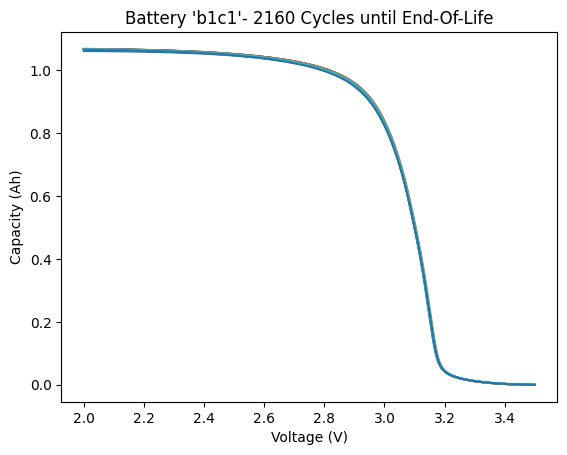

In [175]:
#print(dataset['cell_life'][train_ind])
print(train_names[0])
print(bat_dict['b1c1']['cycle_life'][0][0])

#plt.figure(figsize=(3.2,2.4))
for cycle in range(1,99,9):
    plt.plot(Vdlin, bat_dict['b1c1']['cycles'][str(cycle)]['Qdlin'])
    plt.title("Battery 'b1c1'- 2160 Cycles until End-Of-Life")
    plt.xlabel('Voltage (V)')
    plt.ylabel('Capacity (Ah)')
plt.show()

b2c4
444.0


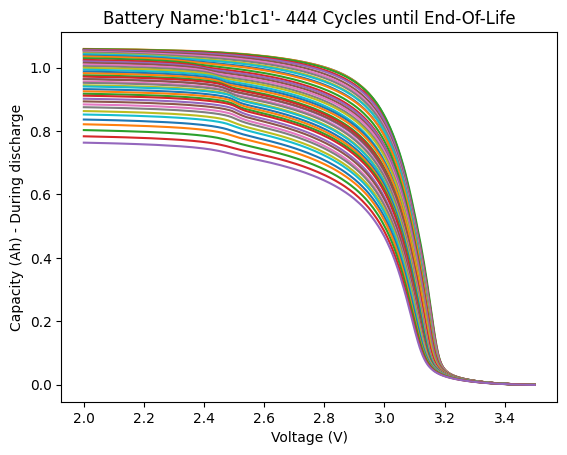

In [176]:
#print(dataset['cell_life'][train_ind])
print(train_names[22])
print(bat_dict['b2c4']['cycle_life'][0][0])

#plt.figure(figsize=(3.2,2.4))
for cycle in range(1,444, 10):
    plt.plot(Vdlin, bat_dict['b2c4']['cycles'][str(cycle)]['Qdlin'])
    plt.title("Battery Name:'b1c1'- 444 Cycles until End-Of-Life")
    plt.xlabel('Voltage (V)')
    plt.ylabel('Capacity (Ah) - During discharge')
plt.show()

b1c1


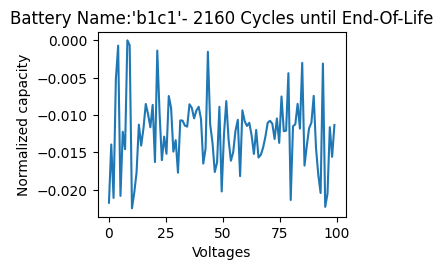

In [177]:
#print(dataset['cell_life'][train_ind])
plt.figure(figsize=(3.2,2.4))
print(train_names[0])
for cycle in range(1):
    plt.plot(Cycles, train_Qdlin[0][cycle])
    plt.title("Battery Name:'b1c1'- 2160 Cycles until End-Of-Life")
    plt.xlabel('Voltages')
    plt.ylabel('Normalized capacity')
plt.show()

b1c1


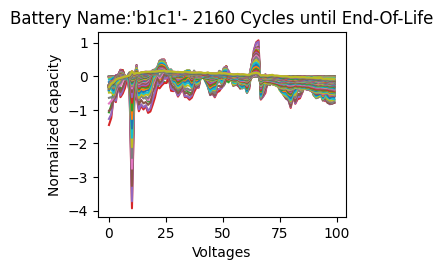

In [178]:
#print(dataset['cell_life'][train_ind])
plt.figure(figsize=(3.2,2.4))
print(train_names[0])
for cycle in range(99):
    plt.plot(Cycles, train_Qdlin[0][cycle])
    plt.title("Battery Name:'b1c1'- 2160 Cycles until End-Of-Life")
    plt.xlabel('Voltages')
    plt.ylabel('Normalized capacity')
plt.show()

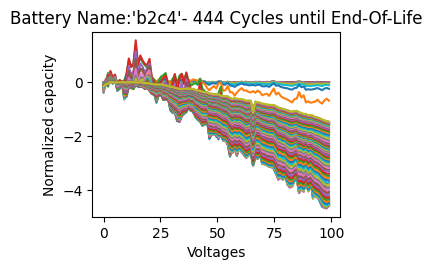

In [179]:
plt.figure(figsize=(3.2,2.4))
for cycle in range(99):
    plt.plot(Cycles, train_Qdlin[22][cycle])
    plt.title("Battery Name:'b2c4'- 444 Cycles until End-Of-Life")
    plt.xlabel('Voltages')
    plt.ylabel('Normalized capacity')
plt.show()

Lifecycle

[ 148.  300.  335.  429.  429.  438.  444.  457.  458.  459.  461.  461.
  462.  463.  465.  466.  468.  471.  477.  478.  480.  481.  483.  485.
  487.  487.  489.  492.  494.  495.  498.  499.  499.  502.  509.  511.
  513.  519.  520.  527.  534.  535.  541.  559.  561.  599.  616.  617.
  625.  636.  648.  651.  667.  691.  702.  703.  704.  709.  713.  719.
  731.  731.  742.  757.  772.  786.  788.  788.  796.  813.  816.  817.
  825.  828.  828.  842.  850.  854.  857.  858.  858.  860.  862.  870.
  870.  876.  876.  880.  917.  923.  932.  935.  940.  966.  989. 1002.
 1009. 1014. 1017. 1028. 1039. 1048. 1051. 1054. 1063. 1074. 1078. 1093.
 1115. 1146. 1155. 1156. 1158. 1284. 1315. 1434. 1638. 1709. 1801. 1836.
 1852. 1935. 2160. 2237.]


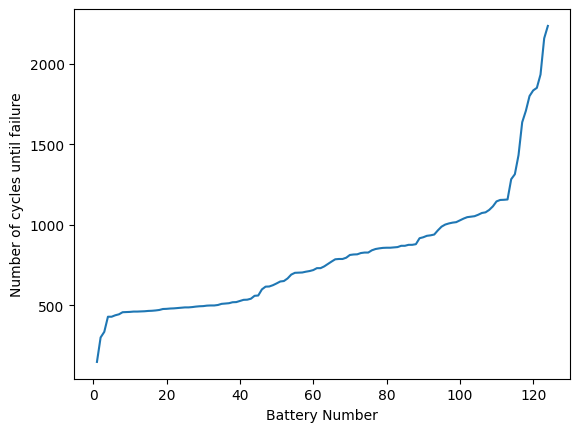

In [180]:
cycles = []
for i in bat_dict.keys():
    cycles.append(bat_dict[i]['cycle_life'][0][0])
    
cycles = np.array(cycles)
cycles = np.sort(cycles)
print(cycles)
plt.plot(np.linspace(1,124,124),cycles)
plt.xlabel('Battery Number')
plt.ylabel('Number of cycles until failure')
plt.show()

In [181]:
from matplotlib import pyplot as plt
from scipy import interpolate

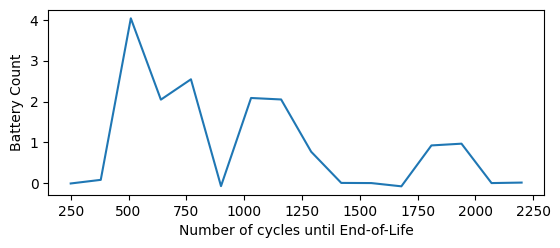

In [182]:
plt.figure(figsize=(6.4,2.4))
# plt.plot(cycles)
plt.xlabel('Number of cycles until End-of-Life')
plt.ylabel('Battery Count')
# plt.show()

y, binEdges = np.histogram(cycles, bins=124)
#plt.hist(data, bins=100, edgecolor='black')

bincenters = 0.5 * (binEdges[1:] + binEdges[:-1])

# x_new, bspline, y_new
x_new = np.linspace(250, 2200, 16)
bspline = interpolate.make_interp_spline(bincenters, y)
y_new = bspline(x_new)

# Plot the new data points
plt.plot(x_new, y_new)

# plt.plot(bincenters, y, '-', c='black')
# plt.show()

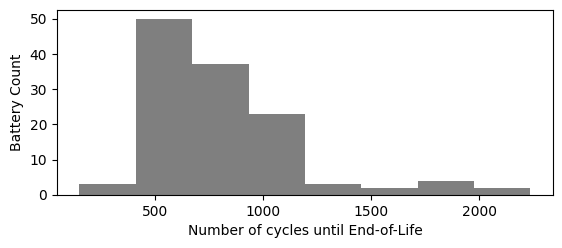

In [183]:
plt.figure(figsize=(6.4,2.4))
plt.hist(cycles, 8,
         histtype='bar',
         facecolor='black',
         alpha=0.5)
plt.xlabel('Number of cycles until End-of-Life')
plt.ylabel('Battery Count')
plt.show()

Severson, K. A., Attia, P. M., Jin, N., Perkins, N., Jiang, B., Yang, Z., Chen, M. H., Aykol, M., Herring, P. K., Fraggedakis, D., Bazant, M. Z., Harris, S. J., Chueh, W. C., & Braatz, R. D. (2019). Data-driven prediction of battery cycle life before capacity degradation. Nature Energy, 4(5), 383–391. doi.org/10.1038/s41560-019-0356-8

Attia, P. M., Severson, K. A., & Witmer, J. D. (2021). Statistical learning for accurate and interpretable battery lifetime prediction. Journal of The Electrochemical Society, 168(9), 090547. doi.org/10.1149/1945-7111/ac2704 	